# W2 Notebook - Reliability analysis at scale

## Recap from W1

</br>
<div style="margin: 8px; padding: 8px; background-color: yellow;">
    <div style="text-align:center; margin-bottom: 8px;">
        <a href="" style="color: black; font-weight: bold;">Go to Menti</a>
    </div>
    <li>Any comments from last week or topics you would like to go over again later on?</li>

 
</div>

## Brief introduction to the Reliability library in Python

_reliability_ is a Python library for reliability engineering and survival analysis. _reliability_ is free to use.

It significantly extends the functionality of scipy.stats and also includes many specialist tools that are otherwise only available in proprietary software. 

Using _reliability_ for analysis and _Python_ for data pre-processing allows for end to end processing of your data from csv's to BI dashboards as well as transparent and repeatable programs.



## Activity

[Link to _reliability_](https://reliability.readthedocs.io/en/latest/). Let's explore this together.

Explore Table of Contents for _reliability_ package

## Import packages we need for this workshop


In [1]:
import pandas as pd
import os 
from reliability.Distributions import Weibull_Distribution, Lognormal_Distribution, Exponential_Distribution #import packages
from reliability.Fitters import Fit_Weibull_2P, Fit_Everything
from reliability.Probability_plotting import plot_points, Weibull_probability_plot, Exponential_probability_plot
import matplotlib.pyplot as plt
import math
import numpy as np
import datetime as dt
from math import nan, isnan

dir_path=os.path.abspath('') #set file path so we can find files in the class folder

## Use of Weibull parameter estimates in Maintenance Strategy development

Here is an example of maintenance strategy development process. Thanks to Assetivity for permission to use this.



![Maintenance strategy development process ](images/RCM_Assetivity.png)


Note the reference in the fixed interval blocks to "does the conditional probability of failure increase with age". 

This is asking if we have a wear-out strategy. 

To have a successful fixed interval strategy we need to understand the distribution of our data, the costs of preventative replacements and the costs of failed replacements. 

Knowing if you have a wear out failure behaviour, knowing the MTTF and knowing the uncertainties on the MTTF estimate are all part of this.

## Any comments or questions about Equipment Strategy development

</br>
<div style="margin: 8px; padding: 8px; background-color: yellow;">
    <div style="text-align:center; margin-bottom: 8px;">
        <a href="" style="color: black; font-weight: bold;">Go to Menti</a>
    </div>
    <li>Comments and questions?</li>

 </div>

## Weibull analysis and why reliability engineers often use Weibull plots to visualise time to event data 

Let's look at Weibull plots for a data set of times-to-failure and explore the following questions?

* How do the plots help us understand Failure behaviours for input to RCM (strategy development and review)
* How do we get mean life values from the plot
* What about early life failure identification
* What about likelihood values for risk estimation

Run the code that follows. 

Note the alpha value sets the $\eta$ (or location) parameter and the $\beta$ value sets the shape parameter in a Weibull distribution. 

We then draw samples from the distribution to represent a data set for times-to-failure.

In [2]:
#Code to plot 4 views of the data defined by the alpha and beta parameters defined in the dist statement

dist = Weibull_Distribution(alpha=30, beta=3.0)  # creates the data
#If you want you can change beta in the line above and re-run the block to see different shaped distributions in the following plots
data = dist.random_samples(40, seed=42)  # draws n samples from the distribution. Seeded for repeatability.


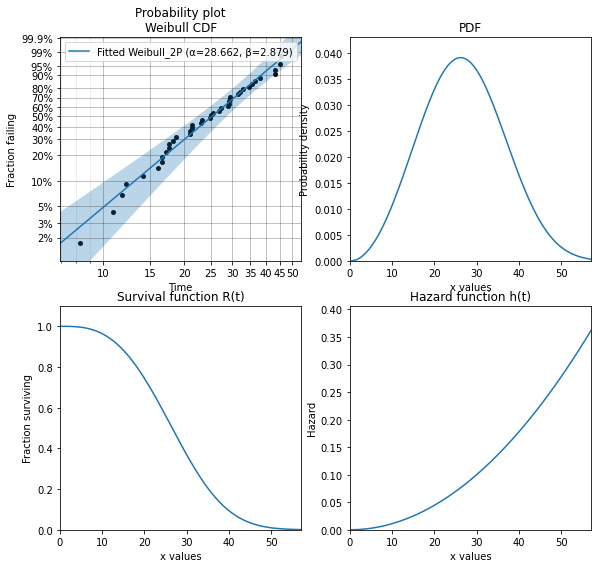

In [3]:
plt.figure(figsize=(16,16))
plt.subplot(221) # Weibull CDF - this is the log-log plot of Unreliability (F(t)) vs Time (traditionally called a Weibull plot)
wb = Fit_Weibull_2P(failures=data, print_results=False)
plt.subplot(222) 
plt.title('Weibull plot')
dist.PDF() # Probability Density Function of the data
plt.title('PDF')
plt.subplot(223) 
dist.SF() # Survival function R(t) 
plt.title('Survival function R(t)')
plt.subplot(224) 
dist.HF() # Hazard function - h(t) = f(t)/ R(t) - conditional probability of failure in the next instant given the item has survived thus far
plt.title('Hazard function h(t)')
plt.show() # Plot the figures

### How we use these plots

As you will have seen from the code block above we can produce 4 views (Weibull plot, PDF, R(t), Hazard Function) on the same data. Each has a purpose for REs.

1. The Weibull plot is used to allow us to test the goodness-of-fit of a Weibull distribution for the data and to see if we have multiple failure modes in the data.

2. The PDF allows us to view the data directly in a way we can intuitively understand (it is essentially a fit to a histogram of our data). 

3. The R(t) (or F(t) plots are an easy way to explain to managers what the probability of survival (or failure) is and the equation for R(t) is used to quantify probability of failure and for use in reliability block diagrams etc.

4. The Hazard function plot is commonly used to explain concepts like the bathtub curve.

## A brief look at some maths

The probability density function (PDF) $f(t)$ of the 2-parameter Weibull distribution is defined for the random variable $T$, which is the lifetime of a component or system (i.e., where $P[T=t]=f(t)$):

<center>$f(t) = \frac{\beta}{\eta}(\frac{t}{\eta})^{\beta -1}e^{-(\frac{t}{\eta})^{\beta}}$</center>

For reliability analysis, $t$ is some measure of usage (e.g., total operating or running time) and $\beta, \eta$ are “shape” and “scale” parameters, and each can also be interpreted as having a specific meaning for reliability engineers.


We use maximum likelihood estimation ( _MLE_ ) to estimate these parameters of the Weibull distribution $(\hat{\beta}, \hat{\eta})$. This, in turn, allows us to estimate the expectation, or centre of mass, of the Weibull probability density function ( _PDF_ ) for $T$, $E[T]$. The estimate of _MTTF_ is then taken as the $E[T]$, as predicted from, and contingent upon the assumptions of, this analysis model. 


Reminders:

The $\beta$ value (shape parameter) tells us something about the failure behaviour. 

Distributions with $\beta = 1$ are said to have exponential (or random) behaviour, this is consistent with events that happen randomly e.g. a stress event, operator error etc. 

Distributions with $\beta > 1$ are said to have wear-out behaviour consistent with wear, corrosion, fatigue and other time or usage based deterioration. 

Finally, $\beta < 1$ are said to have wear-in behaviour due to early life failures often associated with commissioning, poor quality work/ products and some electronics that fail the first time they are used.


The $\eta$ value (location parameter) is important in estimating the mean time to failure. For data with a good fit to a Weibull distribution with $\beta = 1$ then the value for $\eta$ = mean of the distribution. 

If $\beta$ is not equal to $1$ then we need to adjust the value for $\eta$ to calculate the mean.

This is done as follows mean = $\eta * \Gamma(1+(1/\beta))$ where $\Gamma(x)$ is the Gamma Function.

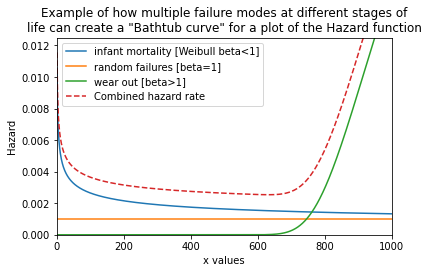

In [4]:
# The bathtub curve (extract from https://reliability.readthedocs.io/en/latest/Creating%20and%20plotting%20distributions.html)

from reliability.Distributions import Weibull_Distribution, Lognormal_Distribution, Exponential_Distribution
xvals = np.linspace(0,1000,1000)
infant_mortality = Weibull_Distribution(alpha=400,beta=0.7).HF(xvals=xvals,label='infant mortality [Weibull beta<1]')
random_failures = Exponential_Distribution(Lambda=0.001).HF(xvals=xvals,label='random failures [beta=1]')
wear_out = Lognormal_Distribution(mu=6.8,sigma=0.1).HF(xvals=xvals,label='wear out [beta>1]')
combined = infant_mortality+random_failures+wear_out
plt.plot(xvals,combined,linestyle='--',label='Combined hazard rate')
plt.legend()
plt.title('Example of how multiple failure modes at different stages of\nlife can create a "Bathtub curve" for a plot of the Hazard function')
plt.xlim(0,1000)
plt.ylim(0,0.0125)
plt.show()



## How to estimate parameters for real data

Let's start with a simple data set chosen for an asset class (excavator boom lift cylinders on a single excavator) where we have only corrective maintenance events. There is no preventative replacement maintenance strategy in place. 

We assume the following:

* All the corrective maintenance work orders (coded as PM01 work order types) are indicative on an end-of-life (EOL) event. 
* Each failure is independent of previous failures.
* There is no repair and reinstallation of a failed lift cylinder.
* The BscStartDate is the date of the failure 
* The time to repair is <<< than the time to next failure and can be ignored.
* That the event on 2009-07-01 was indeed a failure event for the cylinder.
* The excavators work 24 hours a day (we know this is not true in practice and we could substite utilised hours for calendar days if we had the data).

Run the code below and look at the table. Note you will have to put in the correct link to where on your computer the Cylinders_1Exc.csv is stored. 

The data of interest is the Runtime_days column containing the life of each cylinder calculated as the difference between the BscStartDate.

In [5]:
#First we import some data as a csv and look at it
data_path1 = os.path.join(dir_path, '../test_data/Cylinders_1Exc.csv')
exc1 = pd.read_csv(data_path1)
#print('Number of rows in this data set',exc1.size)
exc1

BscStartDate AssetFuncLoc   WONumber WO_type                                   WO_text   Cost  Runtime_days
0    1/07/2006      EXD0004  101798796    PM01  Warranty Vendor to c/o LHS boom cylinder      0           NaN
1   27/03/2007      EXD0004  100246648    PM01                         LHS Boom Cyl Bush  11575           269
2   28/09/2007      EXD0004  100873629    PM01                   LH Boom Cyl replacement   9819           185
3   14/05/2009      EXD0004  101730966    PM01               Change out lh boom cylinder  27718           594
4    1/07/2009      EXD0004  101798800    PM01               Change out lH boom cylinder    460            48
5   31/01/2011      EXD0004  102527461    PM01                   CHANGE OUT L/H BOOM CYL   7046           579
6   23/11/2011      EXD0004  102522560    PM01                 Replace l/h boom cylinder  42544           296

We can see there are 7 events. 
We do not know the life of the '0' event on 1/07/2006 so we only use this record as the basis for determining the life of the following item (269 days). 


### Calculate a point estimate of MTBF for this excavator cylinder data set

In [6]:
# First let's determine a point estimate for the MTBF (in days)
from datetime import date
d0 = date(2006, 7, 1)
d1 = date(2011, 11, 23)
delta = d1 - d0

# Edit the number of events
timeOntest=delta.days
event=6
MTBFExc1=timeOntest/event
print('MTBF in days', MTBFExc1)

MTBF in days 328.5


### Visualise the individual time-to-failures 

Reminder the MTBF in days is 328.5


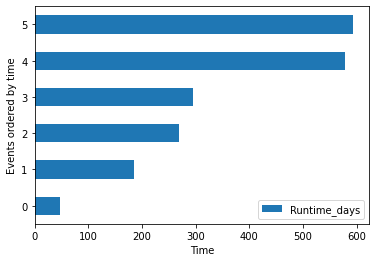

In [7]:
# Next let's visualise the life data as an ordered list

exc1failuretimes=exc1.filter(['Runtime_days']) # extract just the column Runtime_days
exc1failuretimes = exc1failuretimes.sort_values(by='Runtime_days',ignore_index=True, ascending=True)
exc1failuretimes.drop([6], axis=0, inplace=True) #remove the row with NaN
#print(exc1failuretimes)
exc1failuretimes.plot.barh() # plot a horizontal bar chart (we can easily visualise things with only 6 points but this can be useful if you have hundreds of points)
plt.xlabel('Time')
plt.ylabel('Events ordered by time')
print('Reminder the MTBF in days is', MTBFExc1)

### What does this data looks like in a Weibull plot and calculate the eta and beta values

In [8]:
#Using the same excavator boom lift cylinders 
df=np.array(exc1['Runtime_days'].tolist())
df = list(filter(lambda x: isnan(x) == False, df))
df

[269.0, 185.0, 594.0, 48.0, 579.0, 296.0]

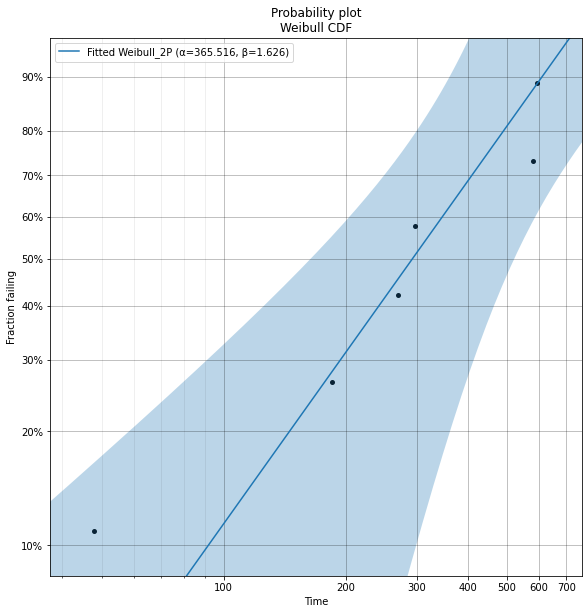

In [9]:
exc1_wplot = Fit_Weibull_2P(failures=df, print_results=False)
plt.show()

In [10]:
print('Weibull Eta value =','%.1f'% exc1_wplot.alpha)
print('Weibull Beta value =','%.1f'% exc1_wplot.beta)
exc1_eta=exc1_wplot.alpha
exc1_beta=exc1_wplot.beta


Weibull Eta value = 365.5
Weibull Beta value = 1.6


In [11]:
exc1_mtbf= exc1_eta*(math.gamma(1+(1/exc1_beta)))
print('The excavator cylinder MTBF value from a Weibull plot is =','%.1f'% exc1_mtbf)
print('MTBF from the point estimate is =', MTBFExc1)
print('The eta value from the Weibull plot is =','%.1f'% exc1_wplot.alpha)


The excavator cylinder MTBF value from a Weibull plot is = 327.2
MTBF from the point estimate is = 328.5
The eta value from the Weibull plot is = 365.5


## Discussion
</br>
<div style="margin: 8px; padding: 8px; background-color: yellow;">
    <div style="text-align:center; margin-bottom: 8px;">
        <a href="" style="color: black; font-weight: bold;">Go to Menti</a>
    </div>
    <li>What does this Weibull plot give us that the point estimate did not?</li>
  
 </div>



### Notes to support the discussion

* The point estimate value of MTBF are close to the MTBF for this data set, but this is not always the case.
* There are only failures in this data set.
* This is only a small dataset but it is indicative of processes and outputs on larger sets.

## What about censoring and suspensions?

In most modern operations we don't allow most items to have run-to-failure strategies. Instead we have fixed interval repair/ replacement, failure-finding and condition-based strategies. These create events classified as 'censored events' which need careful statistical handling. There are different types of censoring. 

Our focus here is on suspensions which we define as a) items that are removed from service before they have failed, b) items still in service when data collection period end. In both cases the actual end of life event has not been observed. In simple terms, unless we account for this, we will *underestimate the life* of the item.



Consider a simple example: Assume we have six small identical pumps installed at the same time 5 years ago. 

* The pump in location 1 failed at 2 years, 
* pump in location 3 failed at 3 years, and 
* the pump in location 6 failed at 4 years. 
* None of the pumps were replaced. 

What's a point estimate for the mean life of this type of pump?

### Have a go
</br>
<div style="margin: 8px; padding: 8px; background-color: yellow;">
    <div style="text-align:center; margin-bottom: 8px;">
        <a href="" style="color: black; font-weight: bold;">Go to Menti</a>
    </div>
    <li>Enter a number for your estimate of the mean life of these six pumps</li>
  
 </div>


In [12]:
#Activity
#Is it?
ans1=(2+3+4)/3
print("Answer 1=",ans1,"years")
#or
ans2=(5+2+3+4+5)/5
print("Answer 2=",ans2,"years")

# In this case we have to account for the pumps in service for the whole of the data collection period that did not fail.
#This is an example of suspension data.

Answer 1= 3.0 years
Answer 2= 3.8 years


### Almost all the data we use for reliability estimation contains censoring. 

Because dealing with censored data has historically been the domain of specialist statistical packages (and not taught to engineers as part of undergraduate engineering courses and not easy to do in Excel) we have had to use expensive custom software to do this analysis. 

Examples include Weibull++, AVSIM and AWB. 

However the recent availability of free and open Python and R packages that do this is changing everything. 

Examples include the Python _reliability_ package we have been using in this program. 

Using these Python packages is often more efficient as Python can also be used for extracting the data from SAP and elsewhere, pre-processing, and analysis as well as visualisation producing code that is transparent and replicable by others. 

### Using figures to explain censoring

Check out the examples at https://reliability.readthedocs.io/en/latest/What%20is%20censored%20data.html

## Worked example with failure AND suspension data

In this example we use data from Mark Ho's UWA PhD thesis published in 2015 on 'A shared reliability database for mobile minng equipment'. The thesis is freely available at 
https://api.research-repository.uwa.edu.au/ws/portalfiles/portal/8153705/Ho_Mark_2015.pdf

We will work with the data set for Front End Loader (FEL) radiators. You can go to page 175 in the thesis if you are interested.

![Front end loader data overview ](images/FEL_rad_summary.png)


![Front end loader failure counts ](images/FEL_rad_failure_counts.png)

Explanatory notes about data in the tables on the previous slide
* 40 assets across 5 organisations. 
* 16 failures requiring complete replacement and 77 partial failures. There were 66 suspensions.
* Each site had only 2-6 failures requiring complete replacement per site.
* Complete failure events are events when the subunit was replaced in its entirety and was 1) in a failed state, 2) showing signs of incipient failure or 3) replaced at a time less than its Fixed Interval replacement.
* Partial failure events are recorded when a subunit is repaired or maintaintable item of the subunit replaced
* End of observation periods is a count of end dates of data observation where the subunit has not experienced a failure, or been preventatively replaced.
* Excluded event count are data points excluded from the study to a a) data points immediately following maintenance and repair contracts, 2) violations of IID testing, c) outlieres with usage hour values greater than 2 standard deviations from the planned interval for FIR.
* We are using the original data set. Some of the excluded event counts were removed due to trend in the data at a specific site for all failures. However as some of the preprocessing was done in Excel, we cannot recreate all the cleaning steps.
* All FEL LDRS were involved in rock handling as production units. They had power ratings of 600-1200 W.
* All times reported are in hours of active use


First we need to load the data set as a csv file. 

In [13]:
#First we import some data as a csv and sort it by ascending order of the value of the Life (in hours)
data_path2 = os.path.join(dir_path, '../test_data/LDR_Rad_AFM_multiCo_FS.csv')
ldr_rad = pd.read_csv(data_path2)
ldr_rad.sort_values(by=['Life'],inplace=True, ascending=False)

We create the following dataframes and lists:
- `failures`: A pandas dataframe containing only valid time-to-failure measurements.
- `right_censored`: A pandas dataframe containing only right censored measurements.
- `failure_times`: List of time-to-failure measurements in ascending order
- `right_censors`: List of right censored measurements in ascending order

print('Number of rows in this data set',ldr_rad.shape) 

We will use these later in the analysis.

In [14]:
ldr_rad.sort_values(by=['Life'],inplace=True, ascending=True)
failures=ldr_rad[ldr_rad['Event_type']==1]
right_censored=ldr_rad[ldr_rad['Event_type']==0]
failures #Scroll down to examine the data set - shows only failures
#right_censored

Life  Event_type Org
41     143           1   A
74     225           1   D
43     298           1   A
2      357           1   E
75     480           1   D
172    738           1   C
79     855           1   D
45     857           1   A
81     945           1   D
82    1035           1   D
124   1127           1   F
83    1215           1   D
125   1228           1   F
85    1305           1   D
127   1527           1   F
86    1725           1   D
11    1836           1   E
88    2070           1   D
48    2357           1   A
49    2565           1   A
16    2618           1   E
17    2686           1   E
179   2782           1   C
18    2907           1   E
175   3070           1   C
52    3107           1   A
89    3210           1   D
20    3247           1   E
21    3332           1   E
129   3443           1   F
90    3600           1   D
91    3750           1   D
131   3840           1   F
133   4454           1   F
134   4482           1   F
163   4550           1   C
92    4740           1   D
93    4755           1   D
181   5084           1   C
25    5117           1   E
137   5173           1   F
96    5415           1   D
97    5715           1   D
178   5776           1   C
140   5943           1   F
31    6307           1   E
99    6345           1   D
141   6391           1   F
32    6409           1   E
35    6902           1   E
100   7485           1   D
182   7497           1   C
101   7605           1   D
184   8313           1   C
102   8340           1   D
143   8369           1   F
58    8770           1   A
144   8806           1   F
145   8947           1   F
180   9409           1   C
171   9500           1   C
59    9560           1   A
148   9977           1   F
104  10005           1   D
149  10309           1   F
46   10467           1   A
38   10727           1   E
150  10893           1   F
170  11713           1   C
61   11935           1   A
39   12019           1   E
62   12043           1   A
167  12550           1   C
173  12650           1   C
108  13035           1   D
64   13108           1   A
65   13170           1   A
109  13455           1   D
174  13733           1   C
110  14490           1   D
111  14925           1   D
68   15505           1   A
69   15651           1   A
156  15668           1   F
157  15708           1   F
158  15747           1   F
113  15960           1   D
114  16200           1   D
115  16620           1   D
159  17115           1   F
116  18060           1   D
71   19219           1   A
117  19350           1   D
118  20055           1   D
119  21390           1   D
72   22256           1   A

In [25]:
number_failures=len(ldr_rad[ldr_rad['Event_type']==1])
number_suspensions=len(ldr_rad[ldr_rad['Event_type']==0])
failure_times = failures['Life'].values.tolist()
right_censors = right_censored['Life'].values.tolist()
print('Number of failures',number_failures)
print('Number of suspensions',number_suspensions)

Number of failures 96
Number of suspensions 89


### It is really important to visualise your raw data 

Using `matplotlib` we can have an initial look at the data. Importantly, this step helps to understand these data prior to fitting any models or making strong model assumptions (Meeker and Escobar, 1998). Results will inform initial decisions made during subsequent model fitting.

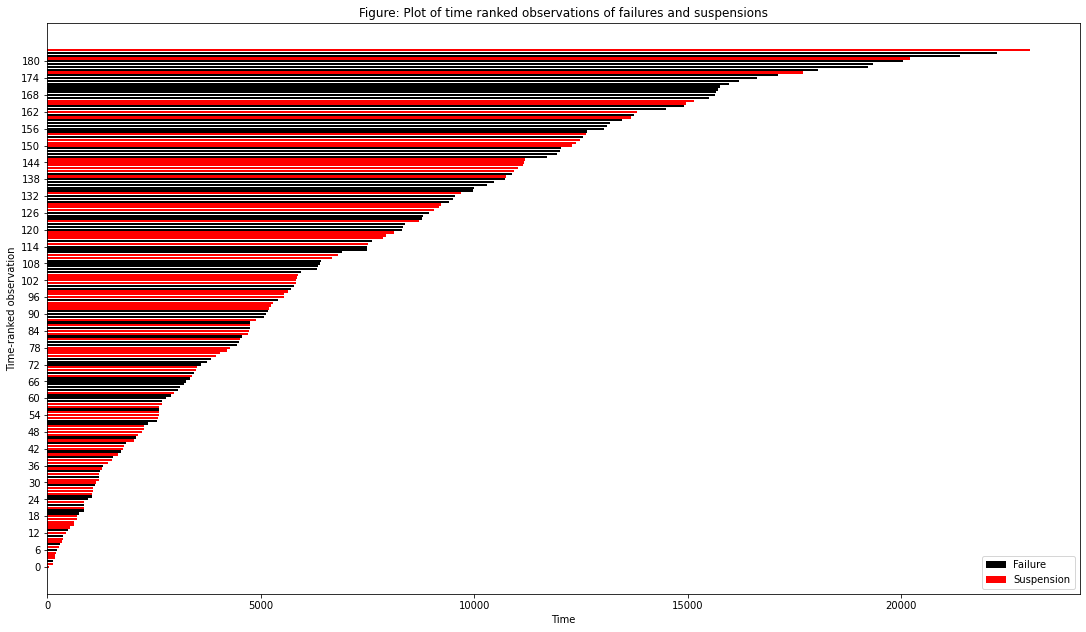

In [17]:
yaxis = np.arange(0, len(ldr_rad), 6)

fig, ax = plt.subplots()

mask1 = ldr_rad['Event_type']==1
mask2 = ldr_rad['Event_type']==0

ax.barh(np.arange(0,len(ldr_rad))[mask1], ldr_rad['Life'][mask1], color='black', label='Failure')
ax.barh(np.arange(0,len(ldr_rad))[mask2], ldr_rad['Life'][mask2], color='red', label='Suspension')

ax.set_yticks(yaxis)
ax.set_yticklabels(yaxis)
ax.set_xlabel('Time')
ax.set_ylabel('Time-ranked observation')
ax.set_title('Figure: Plot of time ranked observations of failures and suspensions')
ax.legend()
fig.set_size_inches(18.5, 10.5)

plt.show()

Next we can inspect the sampled frequencies as a histogram. What PDF distribution does this look like?

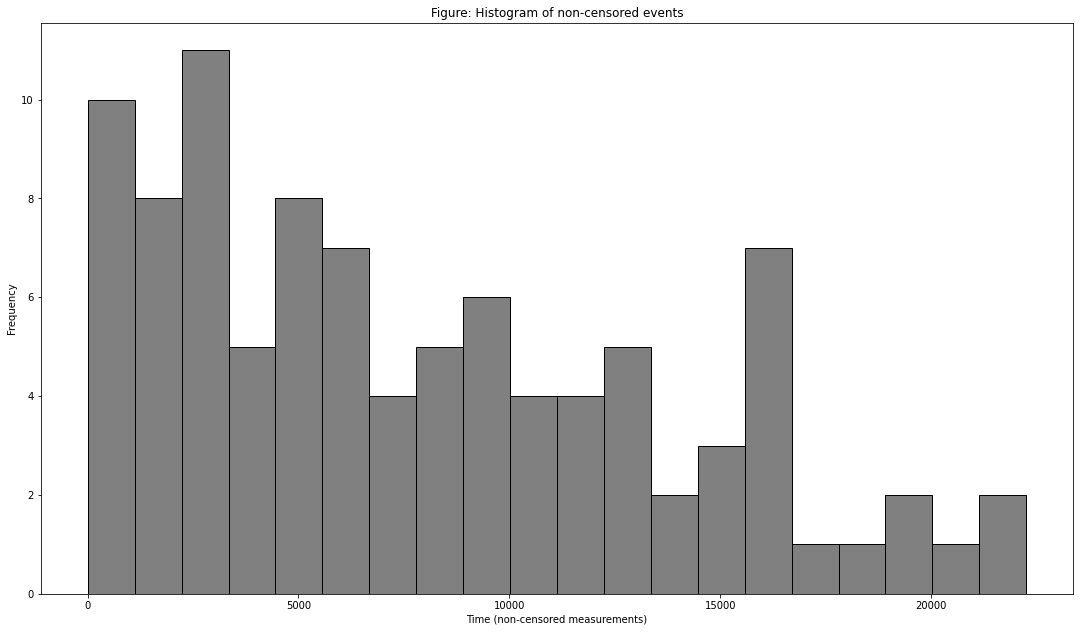

In [18]:
fig, ax = plt.subplots()

bins = np.arange(0, max(failures['Life'])+10, 10)
plt.hist(failures['Life'], bins=20, range=(5, max(failures['Life'])), 
         color='grey', edgecolor='black') #Change the number of bins to get different views of the data

ax.set_xlabel('Time (non-censored measurements)')
ax.set_ylabel('Frequency')
ax.set_title('Figure: Histogram of non-censored events')
fig.set_size_inches(18.5, 10.5)

plt.show()

### Probability plots
Next we construct probability plots, as suggested in Meeker and Escobar (1998), to identify which distribution(s) may provide a good approximation of these data. 

We can use the `Fit_Everything` function from the reliability package. 

This function returns parameter estimates, a plot of the CDF and PDF of a distribution against the histogram of failure data, and probability plots. For now, we'll just look at the probability plots and parameter estimates.

From the <a href="https://reliability.readthedocs.io/en/latest/Probability%20plots.html#what-does-a-probability-plot-show-me">Reliability docs</a>:

These probability plots show how well the data is modelled by a particular distribution. The axes are scaled in such a way that the fitted distribution's CDF appears to be a straight line. A reminder about the plots:

- The y-axis is the unreliability, $\hat{F}(t)$.
- The x-axis is time, $t$.
- If the empirical CDF of the failure data (the black dots) lie on the straight line then the distribution is a good fit for the data.
- We usually tolerate a little bit of deviation at the tails.

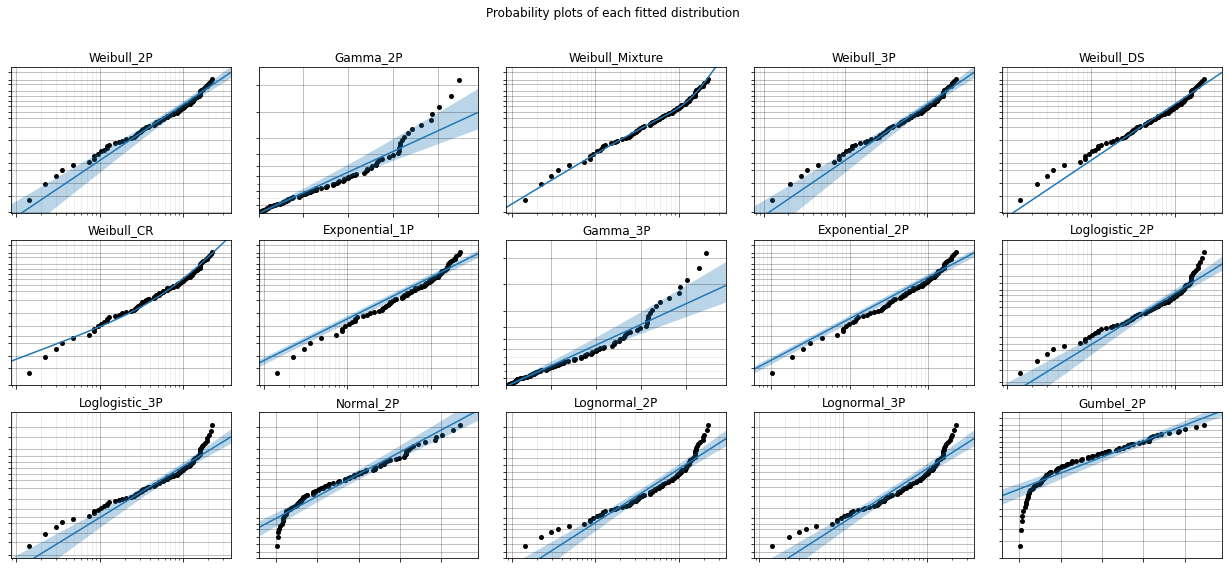

In [19]:
results = Fit_Everything(failures=failure_times,right_censored=right_censors,print_results=False, 
                                    show_histogram_plot=False, show_PP_plot=False, show_best_distribution_probability_plot=False)

### Interpretation of the presented probability plots:
The plotted $\hat{F}(t)$ against $t$ on the 2 and 3 parameter Weibull, 2 and 3 parameter, Normal and Weibull mixture scales  look fairly linear, 

The default setting used by the Fitters package is the BIC goodness of fit to help select a distribution. It identifies the Weibull 2P distribution.

In [20]:
print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)

The best fitting distribution was Weibull_2P which had parameters [1.21398595e+04 1.34548999e+00 0.00000000e+00]


### Fit preferred model and estimate parameters

Fit the Weibull model using the `reliability` package. Note we are including both failures AND SUSPENSIONS in the data set.

Obviously on failures appear as black dots on the Weibull plot but the suspensions impact the position of the black dot on the y axis of the plot.

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 96/89 (48.10811% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         12139.9         927.209     10452   14100.2
     Beta         1.34549        0.108353   1.14903   1.57554 

Goodness of fit    Value
 Log-likelihood -998.642
           AICc  2001.35
            BIC  2007.73
             AD  4.94184 



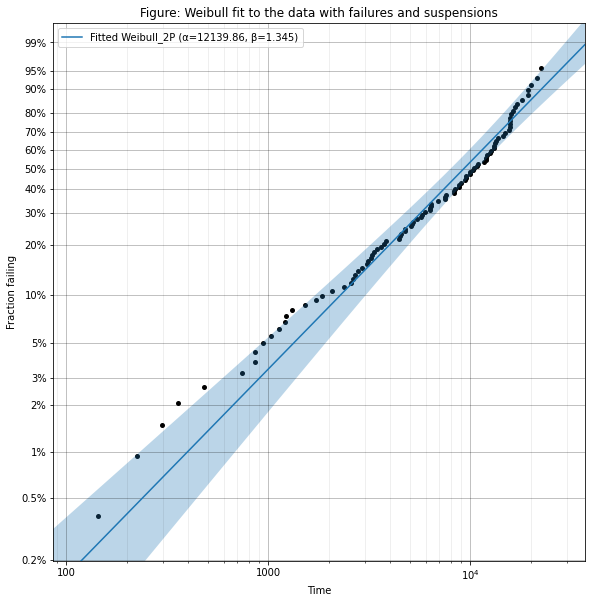

In [21]:
weibull_fit = Fit_Weibull_2P(failures=failure_times, 
                                   right_censored=right_censors)
plt.title("Figure: Weibull fit to the data with failures and suspensions")
plt.show()

### Inference

What can we learn about the reliability of this component or system from this fitted model?

In [22]:
print(r"Estimate for beta is "+"{:.2f}".format(weibull_fit.beta))
print(r"Estimate for the upper CI for beta is "+"{:.2f}".format(weibull_fit.beta_upper))
print(r"Estimate for the lower CI for beta is "+"{:.2f}".format(weibull_fit.beta_lower))

print(r"Estimate for eta is "+"{:.0f}".format(weibull_fit.alpha), "hours")
print(r"Estimate for the upper CI for eta is "+"{:.0f}".format(weibull_fit.alpha_upper), "hours")
print(r"Estimate for the lower CI for eta is "+"{:.0f}".format(weibull_fit.alpha_lower), "hours")

# Discuss what these values mean and how to interpret the confidence interval

Estimate for beta is 1.35
Estimate for the upper CI for beta is 1.58
Estimate for the lower CI for beta is 1.15
Estimate for eta is 12140 hours
Estimate for the upper CI for eta is 14100 hours
Estimate for the lower CI for eta is 10452 hours


### What would have happened if we had only plotted the failures and not the suspensions?


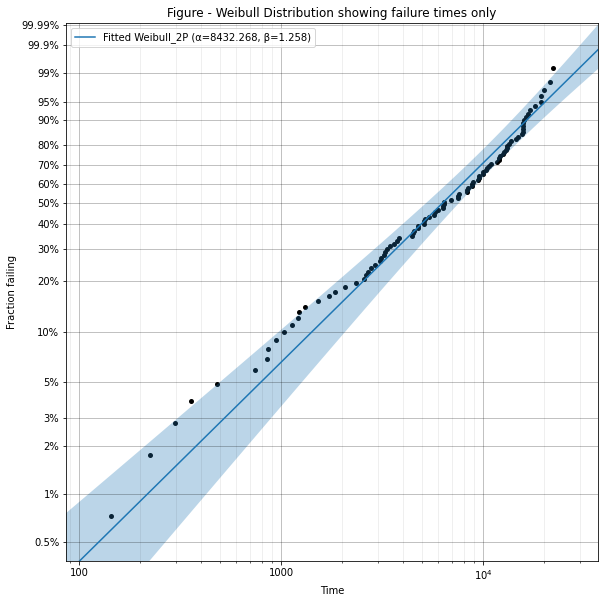

Estimate for beta is 1.3
Estimate for eta is 8432
This compares to an eta value from the earlier Weibull plot using failures AND suspensions of 12140 hours


In [23]:
weibull_f_only=Fit_Weibull_2P(failures=failure_times, print_results=False, show_probability_plot=True)
plt.title('Figure - Weibull Distribution showing failure times only')
plt.show()
print(r"Estimate for beta is "+"{:.1f}".format(weibull_f_only.beta))
print(r"Estimate for eta is "+"{:.0f}".format(weibull_f_only.alpha))
print(r"This compares to an eta value from the earlier Weibull plot using failures AND suspensions of "+"{:.0f}".format(weibull_fit.alpha), "hours" )

### Answer questions 

Such as "what is the probability Loader Radiator unit will experience a failure mode before 2 calendar years resulting in downtime?"

We can plot the Failure function $F(t)$ and estimate the value of F(t) at t=17520 calendar.

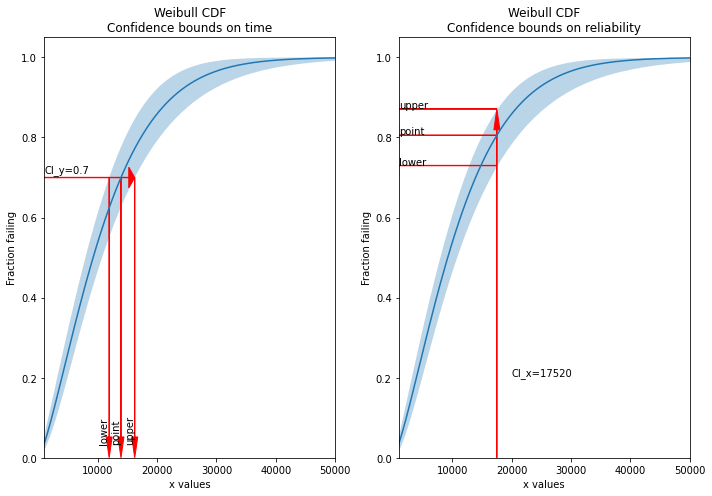

In [30]:
fit = Fit_Weibull_2P(failures=failure_times, right_censored=right_censors,show_probability_plot=False,print_results=False)
plt.figure(figsize=(10,7))
plt.subplot(121)
arrow_x = 1000
arrow_y = 0.052
X_lower,X_point,X_upper = fit.distribution.CDF(CI_type='time',CI_y=0.7)
plt.arrow(x=0,y=0.7,dx=X_upper,dy=0,color='red',head_width=arrow_y,head_length=arrow_x,length_includes_head=True)
plt.arrow(x=X_lower,y=0.7,dx=0,dy=-0.7,color='red',head_width=arrow_x,head_length=arrow_y,length_includes_head=True)
plt.arrow(x=X_point,y=0.7,dx=0,dy=-0.7,color='red',head_width=arrow_x,head_length=arrow_y,length_includes_head=True)
plt.arrow(x=X_upper,y=0.7,dx=0,dy=-0.7,color='red',head_width=arrow_x,head_length=arrow_y,length_includes_head=True)
plt.xlim(1000,50000)
plt.ylim(0,1.05)
plt.text(x=1000,y=0.705,s='CI_y=0.7',va='bottom')
plt.text(x=X_lower,y=0.035,s='lower',va='bottom',ha='right',rotation=90)
plt.text(x=X_point,y=0.035,s='point',va='bottom',ha='right',rotation=90)
plt.text(x=X_upper,y=0.035,s='upper',va='bottom',ha='right',rotation=90)
plt.title('Weibull CDF\nConfidence bounds on time')
plt.subplot(122)
Y_lower,Y_point,Y_upper = fit.distribution.CDF(CI_type='reliability',CI_x=17520)
plt.arrow(x=17520,y=0,dx=0,dy=Y_upper,color='red',head_width=arrow_x,head_length=arrow_y,length_includes_head=True)
plt.arrow(x=17520,y=Y_lower,dx=-17520,dy=0,color='red',head_width=arrow_y,head_length=arrow_x,length_includes_head=True)
plt.arrow(x=17520,y=Y_point,dx=-17520,dy=0,color='red',head_width=arrow_y,head_length=arrow_x,length_includes_head=True)
plt.arrow(x=17520,y=Y_upper,dx=-17520,dy=0,color='red',head_width=arrow_y,head_length=arrow_x,length_includes_head=True)
plt.xlim(1000,50000)
plt.ylim(0,1.05)
plt.text(x=20000,y=0.2,s='CI_x=17520',va='bottom')
plt.text(x=1000,y=Y_lower+0.002,s='lower')
plt.text(x=1000,y=Y_point+0.002,s='point')
plt.text(x=1000,y=Y_upper+0.002,s='upper')
plt.title('Weibull CDF\nConfidence bounds on reliability')
plt.tight_layout()
plt.show()

### Other considerations

Once you have the data set of failure and suspension times there is an endless recipe of scripts you can run to do analysis. Check out the [_reliability_ web site](https://reliability.readthedocs.io/en/latest/)

Other analyses commonly used in practice are

* [Kaplan-Meier (non-parametric plot)](https://reliability.readthedocs.io/en/latest/Kaplan-Meier.html)
* [Mixture models - when there is more than one failure mode](https://reliability.readthedocs.io/en/latest/Mixture%20models.html) 
* [Competing risks - failure modes that are competing to end the life](https://reliability.readthedocs.io/en/latest/Competing%20risk%20models.html)


### What is the challenge then?

For reliability engineers working on in-service assets the main challenge is forming the data frame. By this we mean processing the data to identify the end of life events and determine if each event has been a failure or a suspension. This takes >80% of the time to do the analysis.

Next week we will look at how to semi-automate these steps.

### Homework for next week

1. Re-run the code from today's class. Change some of the values and see what happens.
2. Import a data set of your own and examine it.
3. Share your experiences with the class next week.